<a href="https://colab.research.google.com/github/UgarteGerardo/TesisIAESP32Esquejes/blob/main/TesisESP32IAEsquejes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from pandas import concat

In [23]:
#Modelado
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import concatenate, random
from pandas import DataFrame, to_datetime, concat
import warnings

Convertir Series a Aprendizaje Supervisado

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  #input sequence (t-n, ..., t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t)' %  (j+1)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ..., t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
  #todo junto
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN Values
  if dropnan:
    agg.dropna(inplace=True)
  return agg



Import CSV Data as Pandas DataFrame

In [25]:
df = pd.read_csv('/content/Data - 2023-10-16 - Prueba de tres dias 13-16. Ordenadocsv.csv')

Select features for temp and humidity

In [26]:
features_to_predict_temperature = ['Temperatura (°C)']
features_to_predict_humidity = ['Humedad (%)']
features_to_predict_light = ['Luz']

Mostrar Record

In [27]:
df.head()

,Fecha,Humedad (%),Luz,Relay,Temperatura (°C)
0,13/10/2023 14:55,46.0,133.33 lx,NaN,28.0
1,13/10/2023 14:55,46.0,133.33 lx,NaN,28.0
2,13/10/2023 14:55,46.0,132.50 lx,NaN,28.0
3,13/10/2023 14:56,46.0,131.67 lx,NaN,28.0
4,13/10/2023 14:56,46.0,131.67 lx,NaN,28.0


In [28]:
print(df.columns)

Index(['Fecha', 'Humedad (%)', 'Luz', 'Relay', 'Temperatura (°C)'], dtype='object')


In [29]:
#Extract numeric values from 'Luz'
df['Luz'] = pd.to_numeric(df['Luz'].str.extract('(\d+\.?\d*)', expand=False), errors='coerce')

In [30]:
# Normalize features using MinMaxScaler
scaler_temperature = MinMaxScaler(feature_range=(0,1))
scaler_humidity = MinMaxScaler(feature_range=(0,1))
scaler_light = MinMaxScaler(feature_range=(0,1))

scaled_values_temperature = scaler_temperature.fit_transform(df[features_to_predict_temperature])
scaled_values_humidity = scaler_humidity.fit_transform(df[features_to_predict_humidity])
scaled_values_light = scaler_light.fit_transform(df[features_to_predict_light])

In [31]:
#Prepare Temp dataset
reframed_temperature = series_to_supervised(scaled_values_temperature, 1, 1)
reframed_temperature.drop(reframed_temperature.columns[2:], axis=1, inplace=True)
values_temperature = reframed_temperature.values
n_train_temperature = int(len(df) *  0.75)
train_temperature = values_temperature[:n_train_temperature, :]
test_temperature = values_temperature[n_train_temperature:, :]
train_x_temperature, train_y_temperature = train_temperature[:, :-1], train_temperature[:,-1]
test_x_temperature, test_y_temperature = test_temperature[:, :-1], test_temperature[:, -1]
train_x_temperature = train_x_temperature.reshape((train_x_temperature.shape[0], 1, train_x_temperature.shape[1]))
test_x_temperature = test_x_temperature.reshape((test_x_temperature.shape[0], 1, test_x_temperature.shape[1]))

In [32]:
#Prepare Humidity dataset
reframed_humidity = series_to_supervised(scaled_values_humidity, 1, 1)
reframed_humidity.drop(reframed_humidity.columns[2:], axis=1, inplace=True)
values_humidity = reframed_humidity.values
n_train_humidity = int(len(df)* 0.75)
train_humidity = values_humidity[:n_train_humidity, :]
test_humidity = values_humidity[n_train_humidity:, :]
train_x_humidity, train_y_humidity = train_humidity[:, :-1], train_humidity[:, -1]
test_x_humidity, test_y_humidity = test_humidity[:, :-1], test_humidity[:, -1]
train_x_humidity = train_x_humidity.reshape((train_x_humidity.shape[0], 1, train_x_humidity.shape[1]))
test_x_humidity = test_x_humidity.reshape((test_x_humidity.shape[0], 1, test_x_humidity.shape[1]))

In [33]:
#Prepare Luz dataset
reframed_light = series_to_supervised(scaled_values_light, 1, 1)
reframed_light.drop(reframed_light.columns[2:1], axis=1, inplace=True)
values_light = reframed_light.values
n_train_light = int(len(df) * 0.75)
train_light = values_light[:n_train_light, :]
test_light = values_light[n_train_light:, :]
train_x_light, train_y_light = train_light[:, :-1], train_light[:, -1]
test_x_light, test_y_light = test_light[:, :-1], test_light[:, -1]
train_x_light = train_x_light.reshape((train_x_light.shape[0], 1, train_x_light.shape[1]))
test_x_light = test_x_light.reshape((test_x_light.shape[0], 1, test_x_light.shape[1]))

Design and train LSTM model for Temp

In [34]:
model_temperature = Sequential()
model_temperature.add(LSTM(150, input_shape=(train_x_temperature.shape[1], train_x_temperature.shape[2])))
model_temperature.add(Dense(units=1))
model_temperature.compile(loss='mae', optimizer='adam')
history_temperature = model_temperature.fit(train_x_temperature, train_y_temperature, epochs=100, batch_size=32, validation_data=(test_x_temperature, test_y_temperature), verbose=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2407 - val_loss: 0.2214
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0272 - val_loss: 0.1924
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0238 - val_loss: 0.1652
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0217 - val_loss: 0.1486
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0205 - val_loss: 0.1390
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0199 - val_loss: 0.1254
Epoch 7/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0179 - val_loss: 0.1135
Epoch 8/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0160 - val_loss: 0.1012
Epoch 9/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0140 - val_loss: 0.0926
Epoch 10/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0141 - val_loss: 0.0807
Epoch 11/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0122 - val_loss: 0.0652
Epoch 12/100
631/631 ━━━━━━━━━━━━━━━━━━━━

Design and train LSTM model for Humidity

In [35]:
model_humidity = Sequential()
model_humidity.add(LSTM(150, input_shape=(train_x_humidity.shape[1], train_x_humidity.shape[2])))
model_humidity.add(Dense(units=1))
model_humidity.compile(loss='mae', optimizer='adam')
history_humidity = model_humidity.fit(train_x_humidity, train_y_humidity, epochs=100, batch_size=32, validation_data=(test_x_humidity, test_y_humidity), verbose=1, shuffle=False)

Epoch 1/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0350 - val_loss: 0.2917
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0227 - val_loss: 0.2709
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0222 - val_loss: 0.2621
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0211 - val_loss: 0.2475
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0203 - val_loss: 0.2388
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0205 - val_loss: 0.2295
Epoch 7/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0197 - val_loss: 0.2227
Epoch 8/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0189 - val_loss: 0.2148
Epoch 9/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0185 - val_loss: 0.2064
Epoch 10/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0174 - val_loss: 0.1984
Epoch 11/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0169 - val_loss: 0.1907
Epoch 12/100
631/631 ━━━━━━━━━━━━━━━━━━━━

Design and train LSTM model for Luz

In [36]:
model_light = Sequential()
model_light.add(LSTM(150, input_shape=(train_x_light.shape[1], train_x_light.shape[2])))
model_light.add(Dense(units=1))
model_light.compile(loss='mae', optimizer='adam')
history_light = model_light.fit(train_x_light, train_y_light, epochs=100, batch_size=32, validation_data=(test_x_light, test_y_light), verbose=1, shuffle=False)

Epoch 1/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2286 - val_loss: 0.0062
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0034 - val_loss: 0.0120
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 7/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 8/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 9/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 10/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 11/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 12/100
631/631 ━━━━━━━━━━━━━━━━━━━━

Make Predictions for Temperature

In [37]:
yhat_train_temperature = model_temperature.predict(train_x_temperature)
train_x_temperature = train_x_temperature.reshape((train_x_temperature.shape[0], train_x_temperature.shape[2]))
inv_yhat_train_temperature = scaler_temperature.inverse_transform(concatenate((yhat_train_temperature, train_x_temperature[:, 1:]), axis=1))
inv_yhat_train_temperature = inv_yhat_train_temperature[:,0]
train_y_temperature = train_y_temperature.reshape((len(train_y_temperature), 1))
inv_yhat_train_temperature = scaler_temperature.inverse_transform(concatenate((train_y_temperature, train_x_temperature[:, 1:]), axis=1))
inv_y_train_temperature = inv_yhat_train_temperature[:,0]

yhat_test_temperature = model_temperature.predict(test_x_temperature)
test_x_temperature = test_x_temperature.reshape((test_x_temperature.shape[0], test_x_temperature.shape[2]))
inv_yhat_test_temperature = scaler_temperature.inverse_transform(concatenate((yhat_test_temperature, test_x_temperature[:,1:]), axis=1))
inv_yhat_test_temperature = inv_yhat_test_temperature[:,0]
test_y_temperature = test_y_temperature.reshape((len(test_y_temperature), 1))
inv_y_test_temperature = scaler_temperature.inverse_transform(concatenate((test_y_temperature, test_x_temperature[:, 1:]), axis=1))
inv_y_test_temperature = inv_y_test_temperature[:,0]


631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Make Predictions for Humidity

In [38]:
yhat_train_humidity = model_humidity.predict(train_x_humidity)
train_x_humidity = train_x_humidity.reshape((train_x_humidity.shape[0], train_x_humidity.shape[2]))
inv_yhat_train_humidity = scaler_humidity.inverse_transform(concatenate((yhat_train_humidity, train_x_humidity[:, 1:]), axis=1))
inv_yhat_train_humidity = inv_yhat_train_humidity[:,0]
train_y_humidity = train_y_humidity.reshape((len(train_y_humidity), 1))
inv_y_train_humidity = scaler_humidity.inverse_transform(concatenate((train_y_humidity, train_x_humidity[:, 1:]), axis=1))
inv_y_train_humidity = inv_y_train_humidity[:,0]

yhat_test_humidity = model_humidity.predict(test_x_humidity)
test_x_humidity = test_x_humidity.reshape((test_x_humidity.shape[0], test_x_humidity.shape[2]))
inv_yhat_test_humidity = scaler_humidity.inverse_transform(concatenate((yhat_test_humidity, test_x_humidity[:,1:]), axis=1))
inv_yhat_test_humidity = inv_yhat_test_humidity[:,0]
test_y_humidity = test_y_humidity.reshape((len(test_y_humidity), 1))
inv_y_test_humidity = scaler_humidity.inverse_transform(concatenate((test_y_humidity, test_x_humidity[:, 1:]), axis=1))
inv_y_test_humidity = inv_y_test_humidity[:,0]

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Make Predictions for Light

In [39]:
yhat_train_light = model_light.predict(train_x_light)
train_x_light = train_x_light.reshape((train_x_light.shape[0], train_x_light.shape[2]))
inv_yhat_train_light = scaler_light.inverse_transform(concatenate((yhat_train_light, train_x_light[:, 1:]), axis=1))
inv_yhat_train_light = inv_yhat_train_light[:, 0]
train_y_light = train_y_light.reshape((len(train_y_light), 1))
inv_y_train_light = scaler_light.inverse_transform(concatenate((train_y_light, train_x_light[:, 1:]), axis=1))
inv_y_train_light = inv_y_train_light[:,0]

yhat_test_light = model_light.predict(test_x_light)
test_x_light = test_x_light.reshape((test_x_light.shape[0], test_x_light.shape[2]))
inv_yhat_test_light = scaler_light.inverse_transform(concatenate((yhat_test_light, test_x_light[:,1:]), axis=1))
inv_yhat_test_light = inv_yhat_test_light[:,0]
test_y_light = test_y_light.reshape((len(test_y_light), 1))
inv_y_test_light = scaler_light.inverse_transform(concatenate((test_y_light, test_x_light[:, 1:]), axis=1))
inv_y_test_light = inv_y_test_light[:,0]

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Plot Model Loss for Temperature

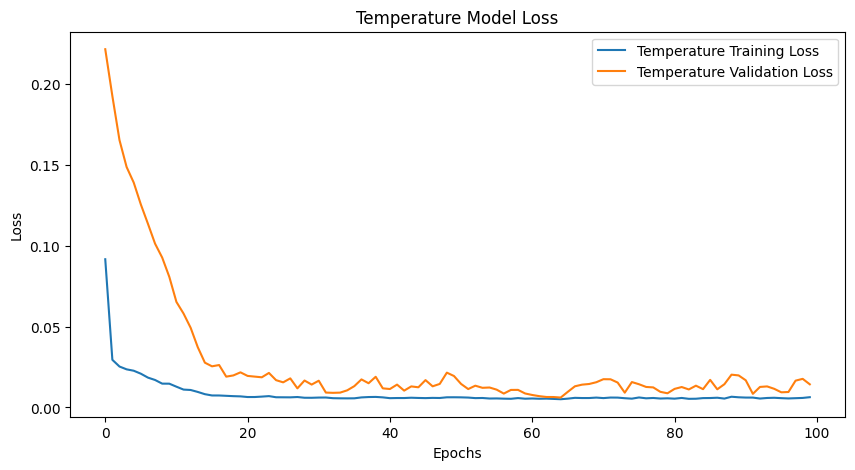

In [40]:
plt.figure(figsize=(10,5))
plt.plot(history_temperature.history['loss'], label='Temperature Training Loss')
plt.plot(history_temperature.history['val_loss'], label='Temperature Validation Loss')
plt.title('Temperature Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot Model Loss for Humidity

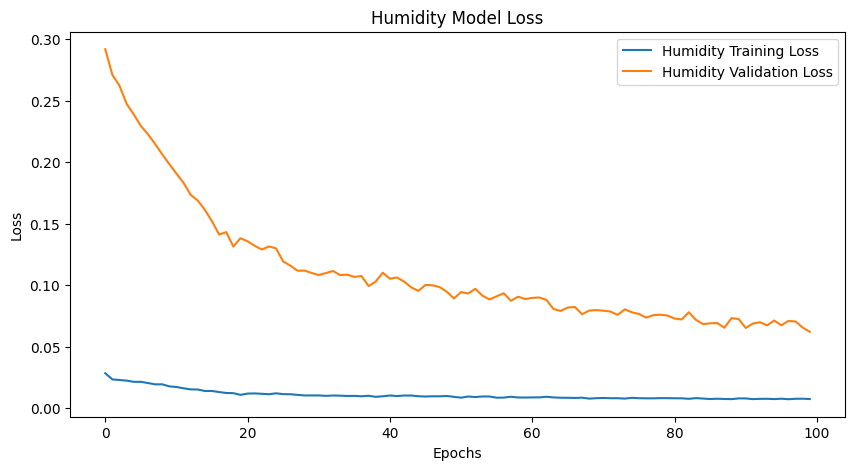

In [43]:
plt.figure(figsize=(10,5))
plt.plot(history_humidity.history['loss'], label='Humidity Training Loss')
plt.plot(history_humidity.history['val_loss'], label='Humidity Validation Loss')
plt.title('Humidity Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot Model Loss for Light

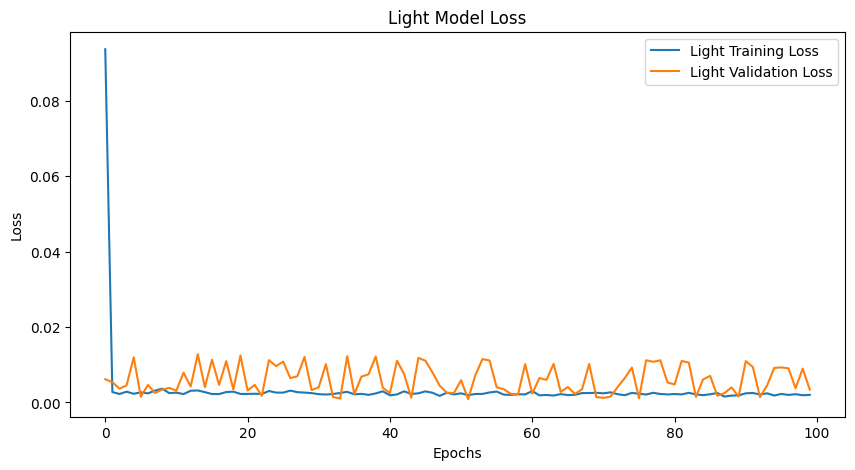

In [44]:
plt.figure(figsize=(10,5))
plt.plot(history_light.history['loss'], label='Light Training Loss')
plt.plot(history_light.history['val_loss'], label='Light Validation Loss')
plt.title('Light Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Calculate RMSE for Temperature, Humidity and Light

Temperature Train RMSE: 0.000
Temperature Test RMSE: 0.220
Humidity Train RMSE: 2.218
Humidity Test RMSE: 2.766
Light Train RMSE: 48.529
Light Test RMSE: 39.761


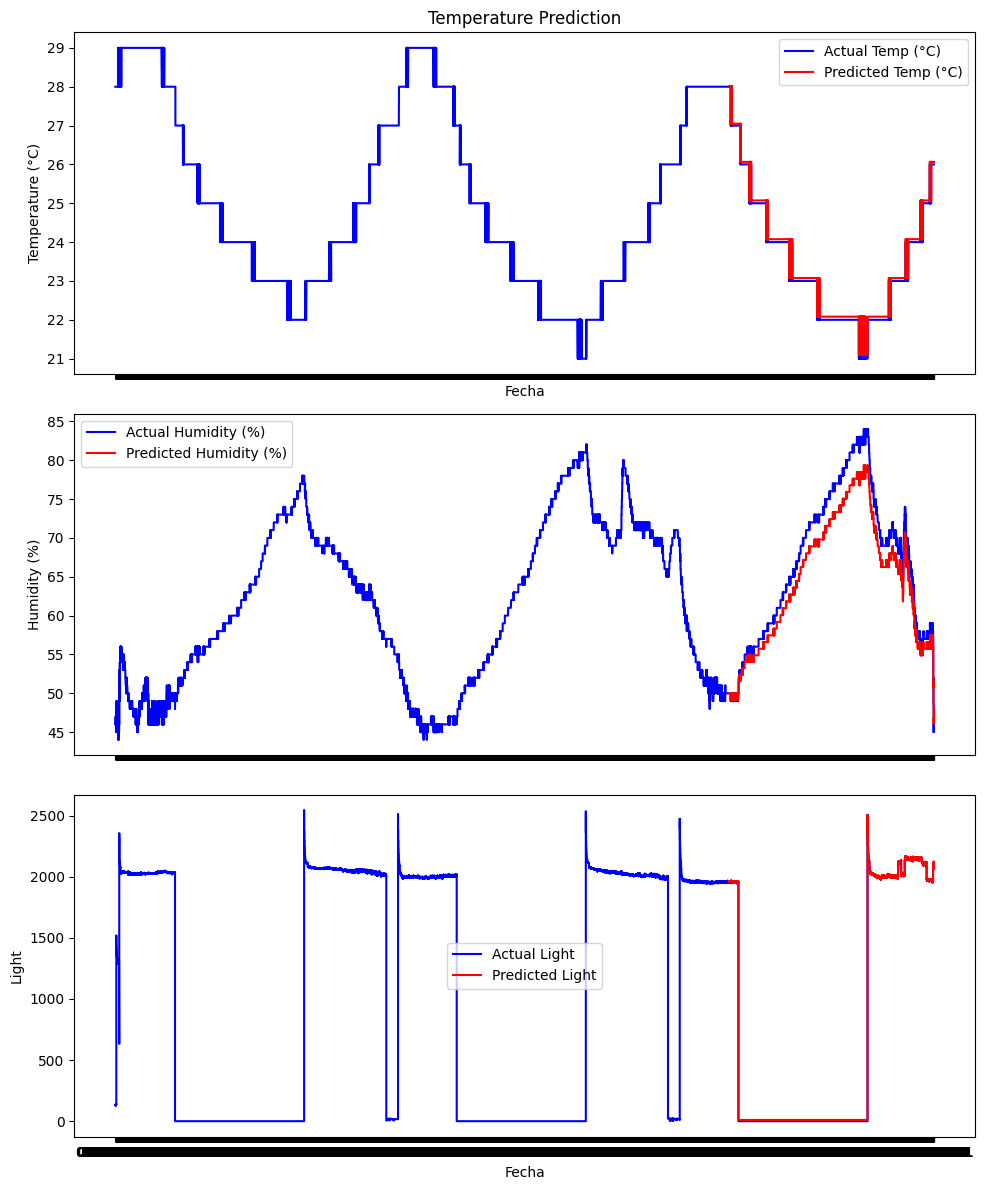

In [50]:
rmse_train_temperature = sqrt(mean_squared_error(inv_y_train_temperature, inv_yhat_train_temperature))
print('Temperature Train RMSE: %.3f' % rmse_train_temperature)

rmse_test_temperature = sqrt(mean_squared_error(inv_y_test_temperature, inv_yhat_test_temperature))
print('Temperature Test RMSE: %.3f' % rmse_test_temperature)

rmse_train_humidity = sqrt(mean_squared_error(inv_y_train_humidity, inv_yhat_train_humidity))
print('Humidity Train RMSE: %.3f' % rmse_train_humidity)

rmse_test_humidity = sqrt(mean_squared_error(inv_y_test_humidity, inv_yhat_test_humidity))
print('Humidity Test RMSE: %.3f' % rmse_test_humidity)

rmse_train_light = sqrt(mean_squared_error(inv_y_train_light, inv_yhat_train_light))
print('Light Train RMSE: %.3f' % rmse_train_light)

rmse_test_light = sqrt(mean_squared_error(inv_y_test_light, inv_yhat_test_light))
print('Light Test RMSE: %.3f' % rmse_test_light)

#Plot the results for Temperature
x0_temperature = list(range(len(train_y_temperature)))
x1_temperature = list(range(len(train_y_temperature), len(train_temperature) + len(test_y_temperature)))

fig_temperature, (ax1_temperature, ax2_temperature, ax3_temperature) = plt.subplots(3, 1, sharex=True, figsize=(10,12))

#Plot for Temperatura (°C)
ax1_temperature.plot(df['Fecha'], df['Temperatura (°C)'], 'b', label='Actual Temp (°C)')
ax1_temperature.plot(df['Fecha'].iloc[x1_temperature], inv_yhat_test_temperature, 'r', label='Predicted Temp (°C)')
ax1_temperature.set_title('Temperature Prediction')
ax1_temperature.set_ylabel('Temperature (°C)')
ax1_temperature.set_xlabel('Fecha')
ax1_temperature.set_title('Temperature Prediction')
ax1_temperature.legend()

#Plot for Humidity
ax2_temperature.plot(df['Fecha'], df['Humedad (%)'], 'b', label='Actual Humidity (%)')
ax2_temperature.plot(df['Fecha'].iloc[x1_temperature], inv_yhat_test_humidity, 'r', label='Predicted Humidity (%)')
ax2_temperature.set_ylabel('Humidity (%)')
ax2_temperature.set_label('Fecha')
ax2_temperature.set_label('Humidity Prediction')
ax2_temperature.legend()

#Plot for Light
ax3_temperature.plot(df['Fecha'], df['Luz'], 'b', label='Actual Light')
ax3_temperature.plot(df['Fecha'].iloc[x1_temperature], inv_yhat_test_light, 'r', label='Predicted Light')
ax3_temperature.set_ylabel('Light')
ax3_temperature.set_xlabel('Fecha')
ax3_temperature.set_label('Light Prediction')
ax3_temperature.legend()


ax1_temperature.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m-%Y'))
ax2_temperature.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m-%Y'))
ax3_temperature.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m-%Y'))

plt.tight_layout()
plt.show()